In [ ]:
!pip install langchain langgraph langchain_groq langchain_openai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 12.5 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPEN_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import MessagesState

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import display, Image


In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [ ]:
def multiply(a:int, b:int) -> int:
  """
  Multiply a and b.

  Args:
    a: First int
    b: Second int

  """
  return (a+b)


def add(a:int, b:int) -> int:
  """
  Adds a and b
  Args:
    a: First int
    b: Second int
  """
  return (a+b)

def divide(a:int, b:int) -> int:
  """
  Divides a and b
  Args:
    a: First int
    b: Second int
  """
  return (a/b)

tools = [add, multiply, divide]

In [ ]:
llm = ChatOpenAI(model = "gpt-4o")
#llm = ChatGroq(model ="deepseek-r1-distill-qwen-32b")

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls= False)

In [ ]:
class MessageState(TypedDict):
  messages: Annotated[list[AnyMessage],add_messages]

In [ ]:
sys_message = SystemMessage(content="You are a helpeful assistant tasked with arithmetic on set on inputs.")

In [ ]:
def assistant(state:MessagesState):
  return {"messages":[llm_with_tools.invoke([sys_message] + state["messages"])]}

In [ ]:
builder = StateGraph(MessagesState)

# Define the node
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define the edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
    )
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

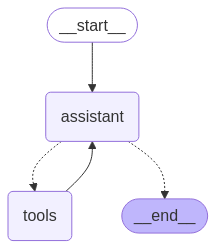

In [ ]:
# Show
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Add 10 and 14. Multiply the output by 2 and divide by 2")]
messages = react_graph.invoke({"messages":messages})

In [ ]:
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 10 and 14. Multiply the output by 2 and divide by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_4dcrF0Nm76Thm1TOWah4XGnS)
 Call ID: call_4dcrF0Nm76Thm1TOWah4XGnS
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================
Tool Calls:
  multiply (call_a9s4Te4a8BSv3AH0IsLoZ2kU)
 Call ID: call_a9s4Te4a8BSv3AH0IsLoZ2kU
  Args:
    a: 24
    b: 2
================================= Tool Message =================================
Name: multiply

26
================================== Ai Message ==================================

My apologies, it seems there was a mistake in my calculation. Let me correct that. The correct output for 24 multiplied by 2 should be 48, not 26. Let's proceed with dividing 48 by 2.

## Agent Memory

In [ ]:
messages = [HumanMessage(content="Add 10 and 14.")]
messages = react_graph.invoke({"messages":messages})
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 10 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_kZl6xmvWGHnSKP6o9LnOXUhj)
 Call ID: call_kZl6xmvWGHnSKP6o9LnOXUhj
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================

The sum of 10 and 14 is 24.


In [ ]:
messages = [HumanMessage(content="Divide that by 2.")]
messages = react_graph.invoke({"messages":messages})
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Divide that by 2.
================================== Ai Message ==================================

It seems like there is a missing context or number that you would like to be divided by 2. Could you please provide the number you want to divide by 2?


### Memory In Agents Using MmeorySaver

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

In [ ]:
memory = MemorySaver()

In [ ]:
react_graph = builder.compile(checkpointer=memory)

In [ ]:
config = {"configurable":{"thread_id":"1"}}

messages = [HumanMessage(content="Add 10 and 14.")]
messages = react_graph.invoke({"messages":messages}, config)
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 10 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_DJcm2lP4iHURj9rpOnDDb6Ey)
 Call ID: call_DJcm2lP4iHURj9rpOnDDb6Ey
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================

The sum of 10 and 14 is 24.


In [ ]:
messages = [HumanMessage(content="Divide that by 2.")]
messages = react_graph.invoke({"messages":messages}, config)
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 10 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_DJcm2lP4iHURj9rpOnDDb6Ey)
 Call ID: call_DJcm2lP4iHURj9rpOnDDb6Ey
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================

The sum of 10 and 14 is 24.
================================ Human Message =================================

Divide that by 2.
================================== Ai Message ==================================
Tool Calls:
  divide (call_i2MoS0Nej0V16hi3eGznBpuj)
 Call ID: call_i2MoS0Nej0V16hi3eGznBpuj
  Args:
    a: 24
    b: 2
================================= Tool Message =================================
Name: divide

12.0
================================== Ai Message ==================================

Dividing 24 by 2